## Example Network using QAOA ##

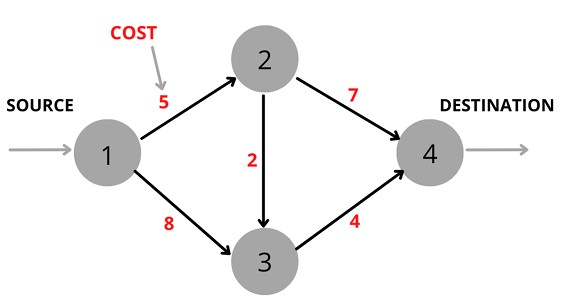


<br>
First we have to create the problem Hamiltonian in the Ising model and add a mixer Hamiltonian for optimizing using QAOA. To generate the Hamiltonian, we use the QUBO method, used in various other combinatorial problems.

In [1]:
from pyqubo import Array,Constraint,Placeholder
from matplotlib import pyplot as plt
import networkx as nx

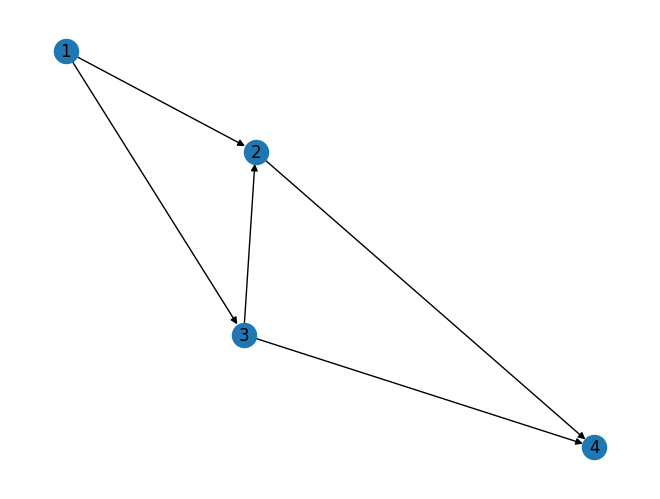

In [2]:
edges = [(1,2),(1,3),(3,2),(2,4),(3,4)]
weights = [5,8,2,7,4] 

x = Array.create(name = 'x', shape =len(edges), vartype = 'BINARY') #SPIN

graph = nx.DiGraph(edges)
nx.draw(graph, with_labels=True)
plt.show()
source = 1
destination = 4

In [3]:
print(x.shape)
print(x)
y = (4*x[0]+x[1])
print(y)

(5,)
Array([Binary('x[0]'), Binary('x[1]'), Binary('x[2]'), Binary('x[3]'), Binary('x[4]')])
((4.000000 * Binary('x[0]')) + Binary('x[1]'))


In [4]:
# model = ((x[0] + x[1] - 1)).compile()
# print(model.to_qubo())

In [5]:
i = 0
fcost = 0
for i in range(len(edges)):
    fcost += (weights[i]*x[i]) ## Put the expression for constraints in

p = 27 # chosen arbitrarily. It represents the penalty for the constraints. Also another parameter that can be varied

## Constraints ##
fcost += p*((x[0] + x[1] - 1)**2) 
fcost += p*((x[0] - x[2] - x[3])**2)
fcost += p*((x[1] + x[2] - x[4])**2)

In [6]:
model = fcost.compile()

In [7]:
print(model.to_qubo())

({('x[4]', 'x[1]'): -54.0, ('x[0]', 'x[0]'): 5.0, ('x[2]', 'x[2]'): 56.0, ('x[4]', 'x[2]'): -54.0, ('x[1]', 'x[2]'): 54.0, ('x[1]', 'x[1]'): 8.0, ('x[3]', 'x[0]'): -54.0, ('x[1]', 'x[0]'): 54.0, ('x[2]', 'x[0]'): -54.0, ('x[2]', 'x[3]'): 54.0, ('x[4]', 'x[4]'): 31.0, ('x[3]', 'x[3]'): 34.0}, 27.0)


In [8]:
linear, quadratic, offset = model.to_ising()
print("Linear Coefficients", linear)
print("Quadratic Coefficients", quadratic)

## The objective function is then made from these linear and quadratic terms ##
## The objective function represents the Problem Hamiltonian Hp ##

Linear Coefficients {'x[0]': -11.0, 'x[1]': 17.5, 'x[2]': 28.0, 'x[3]': 17.0, 'x[4]': -11.5}
Quadratic Coefficients {('x[0]', 'x[1]'): 13.5, ('x[0]', 'x[2]'): -13.5, ('x[2]', 'x[3]'): 13.5, ('x[0]', 'x[3]'): -13.5, ('x[2]', 'x[4]'): -13.5, ('x[1]', 'x[2]'): 13.5, ('x[1]', 'x[4]'): -13.5}


In [9]:
#s = 'x['+str(0)+']'
#print(linear.get(s))

In [10]:
# print(int(list(quadratic.keys())[0][1][2]))

The above coefficients correspond to the following Objective Function:

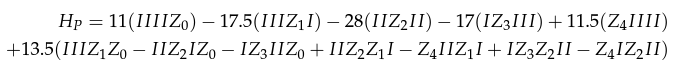

<br>
This Objective function ultimately corresponds to the following circuit:

<img src="qaoa.png">

In [11]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import string
import time

In [12]:
# AWS imports: Import Braket SDK modules
!pip install amazon-braket-sdk
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask

In [13]:
def create_circuit(beta, gamma):
    ## initializing the initial qubit state with H gates ##
    circuit = Circuit()
    n_qubits = len(edges)

    for qubit in range(n_qubits):
        circuit.h(qubit)
    
    ## Implementing the problem Hamiltonian ##
    for qubit in range(n_qubits):
        linear_coeff = linear.get('x['+str(qubit)+']')
        circuit = circuit.rz(qubit, -1*linear_coeff)

    #Algorithmic method to add the ZZ gates - CHECK TO SEE IF IT AFFECTS THE RESULTS(it should'nt because they commute)
    for i in range(len(quadratic)):
        qubit_1 = int(list(quadratic.keys())[i][0][2])
        qubit_2 = int(list(quadratic.keys())[i][1][2])

        quadratic_coeff = quadratic.get(('x['+str(qubit_1)+']', 'x['+str(qubit_2)+']'))
        
    # The Ising-Coupling Gate
        #circuit.zz(qubit_1, qubit_2, quadratic_coeff*gamma)
        circuit.cnot(control=qubit_1, target=qubit_2)
        circuit.rz(qubit_2, quadratic_coeff*gamma)
        circuit.cnot(control=qubit_1, target=qubit_2)
    
    ## Implementing the Mixer Hamiltonian ##
    for qubit in range(n_qubits):
        circuit.rx(qubit, 2*beta) # theta=2*beta because rx rotates the qubit about X by theta/2 angle
    return circuit

In [14]:
circuit = create_circuit(0.28517317, -5.05969577)
#device = LocalSimulator()
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
shots = 1000
result = device.run(circuit, shots).result()
counts = result.measurement_counts
print(counts)

Counter({'10101': 130, '11100': 97, '10011': 75, '01001': 71, '00111': 65, '00101': 63, '00000': 44, '11011': 40, '10001': 37, '11010': 34, '11101': 33, '10000': 33, '10010': 32, '10111': 30, '10100': 27, '00001': 23, '01110': 22, '01000': 20, '01101': 18, '11000': 15, '11110': 14, '00011': 12, '00110': 11, '00010': 11, '01011': 10, '01100': 9, '11111': 7, '11001': 6, '00100': 6, '10110': 3, '01111': 2})


* <b>Remember that there are 3 parameters that can be varied - beta, gamma and penalty p </b>

In [15]:
## Expectation value of the Hamiltonian is basically the expected cost value which we can get from an average of the
## cost values over all states that have occurred ##
def compute_expectation(counts, shots):
    
    expectation = 0
    sum = 0
    states = list(counts.keys())
    for i in range(len(states)):
        state = states[i] # string variable of the current qubit states
        state_cost = 0
        for j in range(len(state)): # Convention of the states is that the left-most qubit is the first qubit q0
            state_cost = state_cost + int(state[j])*weights[j]
        
        expectation = expectation + state_cost*counts.get(state)
        
    expectation /= 1000
    # print(expectation)
    return expectation

In [16]:
## Now we measure the circuit ##
def expectation_execute_circuit(param):
    ## Set up the device to run the circuit
    device = LocalSimulator()
    
    ## QAOA parameters to be optimized such that the eigenvalue Cost(β, γ) can be minimized ##
    beta = param[0]
    gamma = param[1]
    
    circuit = create_circuit(beta, gamma)
    
    shots = 1000
    result = device.run(circuit, shots).result()
    counts = result.measurement_counts
    
    return compute_expectation(counts, shots)    

In [17]:
## Classical Optimizer ##

from scipy.optimize import minimize

res = minimize(expectation_execute_circuit,
               [1.0, 1.0],
               method='SLSQP') # COBYLA
print(res)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 12.717
       x: [ 3.781e+04  6.362e+03]
     nit: 12
     jac: [ 1.745e+06 -1.564e+07]
    nfev: 156
    njev: 12


## Analyzing the Results

In [18]:
beta = res.get('x')[0]
gamma = res.get('x')[1]
circuit = create_circuit(beta, gamma)

device = LocalSimulator()
result = device.run(circuit, shots = 1000).result()
counts = result.measurement_counts

print(counts)

len(counts.keys())
# plot using Counter
#plt.bar(counts.keys(), counts.values())
#plt.xlabel('bitstrings')
#plt.ylabel('counts')

Counter({'10101': 90, '01110': 89, '10010': 81, '11111': 70, '01001': 62, '11011': 48, '00111': 46, '00100': 44, '11000': 42, '00001': 40, '01000': 39, '00011': 39, '01100': 30, '01011': 28, '10100': 26, '11001': 26, '00110': 24, '00101': 22, '11100': 22, '00000': 21, '10000': 18, '00010': 18, '11101': 14, '11110': 11, '11010': 11, '10111': 10, '01111': 7, '10011': 7, '01101': 6, '10110': 5, '10001': 2, '01010': 2})


32

In [19]:
#Carrying out annealing using dwave-neal

def anneal(model):
 import neal
 sampler = neal.SimulatedAnnealingSampler()
 bqm = model.to_bqm()
 sampleset = sampler.sample(bqm, num_reads=10)
 decoded_samples = model.decode_sampleset(sampleset)
 best_sample = min(decoded_samples, key=lambda x: x.energy)
 return best_sample.sample

res_neal = anneal(model)
print(res_neal)




{'x[0]': 1, 'x[1]': 0, 'x[2]': 1, 'x[3]': 0, 'x[4]': 1}


In [20]:
!pip install dwave-ocean-sdk --user --no-warn-script-location

In [21]:
from dwave.cloud import Client
# Connect using the default or environment connection information
with Client.from_config() as client:

    # Load the default solver
    solver = client.get_solver()

    # Build a random Ising model to exactly fit the graph the solver supports
    linear, quadratic, offset = model.to_ising()

    # Send the problem for sampling, include solver-specific parameter 'num_reads'
    computation = solver.sample_ising(linear, quadtratic, num_reads=100)

    # Print the first sample out of a hundred
    print(computation.samples[0])

ValueError: API token not defined